# MAVLink Anomaly Detection Using Machine Learning

This notebook implements anomaly detection for MAVLink messages using Isolation Forest and Local Outlier Factor (LOF) algorithms.

In [10]:
# Define the path to the pcap files and the output directory
csv_directory = "../datasets/mavlink"
output_directory = "./model_output"

In [11]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (confusion_matrix, classification_report,
                           roc_curve, precision_recall_curve, auc)
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.models import Model

In [12]:
plt.style.use('ggplot')
sns.set_palette("husl")

## 1. Load Data

In [13]:
def load_mavlink_data(data_dir):
    """Load all CSV files from directory and combine them"""
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Directory {data_dir} does not exist")

    data_path = Path(data_dir)
    all_data = []
    
    index = 0
    for csv_file in os.listdir(data_dir):
        if csv_file.endswith('.csv'):
          df = pd.read_csv(data_path / csv_file)
          # Add source file as a column
          df['source_file'] = csv_file
          all_data.append(df)
          index += 1

          print(f"File Loaded. {index}: {csv_file} - {len(df)} records")
    
    return pd.concat(all_data, ignore_index=True)

# Load all data
df = load_mavlink_data(csv_directory)
print(f"Loaded {len(df)} records from {df['source_file'].nunique()} files")

# Display basic statistics
print("\nDataset Overview:")
print(df.info())

/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 1: mavlink_data_20241101_160537.csv - 59671 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (75) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 2: mavlink_data_20241101_161005.csv - 65792 records
File Loaded. 3: mavlink_data_20241031_102918.csv - 1 records
File Loaded. 4: mavlink_data_20241031_103254.csv - 1 records
File Loaded. 5: mavlink_data_20241118_000809_ggd.csv - 4273 records
File Loaded. 6: mavlink_data_20241031_103524.csv - 2376 records
File Loaded. 7: mavlink_data_20241101_170019.csv - 39119 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (38,88,99,101,120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 8: mavlink_data_20241101_151428.csv - 44798 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (82,112) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (38,88,99,119) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 9: mavlink_data_20241101_162424.csv - 90471 records
File Loaded. 10: mavlink_data_20241117_234604_gpj.csv - 15126 records
File Loaded. 11: mavlink_data_20241101_153956.csv - 1 records
File Loaded. 12: mavlink_data_20241031_102358.csv - 21851 records
File Loaded. 13: mavlink_data_20241031_102619.csv - 2528 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 14: mavlink_data_20241101_154428.csv - 72904 records
File Loaded. 15: mavlink_data_20241101_155905.csv - 159 records
File Loaded. 16: mavlink_data_20241031_103539.csv - 3629 records
File Loaded. 17: mavlink_data_20241101_152514.csv - 616 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 18: mavlink_data_20241101_152504.csv - 81420 records
File Loaded. 19: mavlink_data_20241101_152510.csv - 3944 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (38,88,99,101,120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (81,92,112) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 20: mavlink_data_20241101_171646.csv - 103644 records
File Loaded. 21: mavlink_data_20241117_234731_rf.csv - 21672 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 22: mavlink_data_20241101_153508.csv - 64930 records
File Loaded. 23: mavlink_data_20241101_161341.csv - 50579 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (34,82,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (82,112) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 24: mavlink_data_20241101_153913.csv - 56409 records
File Loaded. 25: mavlink_data_20241117_234716_rn.csv - 13760 records
File Loaded. 26: mavlink_data_20241031_103228.csv - 22775 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)
/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (87,98,99,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 27: mavlink_data_20241101_170936.csv - 103923 records
File Loaded. 28: mavlink_data_20241031_102913.csv - 33031 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (87,98,99,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 29: mavlink_data_20241101_163432.csv - 135705 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (87,98,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 30: mavlink_data_20241101_151906.csv - 59743 records


/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2365690820.py:12: DtypeWarning: Columns (34,82,93,95,114) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path / csv_file)


File Loaded. 31: mavlink_data_20241101_164607.csv - 76878 records
Loaded 1251729 records from 31 files

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1251729 entries, 0 to 1251728
Columns: 162 entries, MCU_temperature to reason
dtypes: float64(151), object(11)
memory usage: 1.5+ GB
None


In [14]:
# Display columns
for col in df.columns:
    print(f"{col}")

MCU_temperature
MCU_voltage
MCU_voltage_max
MCU_voltage_min
Vcc
Vservo
accel_weight
afx
afy
afz
airspeed_variance
alt
alt_ellipsoid
alt_error
altitude
approach_x
approach_y
approach_z
aspd_error
autopilot
base_mode
battery_function
battery_remaining
brkval
charge_state
chunk_seq
clipping_0
clipping_1
clipping_2
cog
compass_variance
coordinate_frame
covariance
current_battery
current_consumed
current_distance
current_height
custom_mode
direction
drop_rate_comm
energy_consumed
eph
epv
error_rp
error_yaw
errors_comm
errors_count1
errors_count2
errors_count3
errors_count4
fault_bitmask
fix_type
flags
freemem
freemem32
h_acc
hdg
hdg_acc
horizontal_fov
id
lat
lat_int
latitude
lng
load
loaded
lon
lon_int
longitude
mavlink_version
mavpackettype
max_distance
min_distance
mission_mode
mission_state
mode
nav_bearing
nav_pitch
nav_roll
omegaIx
omegaIy
omegaIz
onboard_control_sensors_enabled
onboard_control_sensors_health
onboard_control_sensors_present
orientation
param_count
param_id
param_index


## 2. Data Visualization

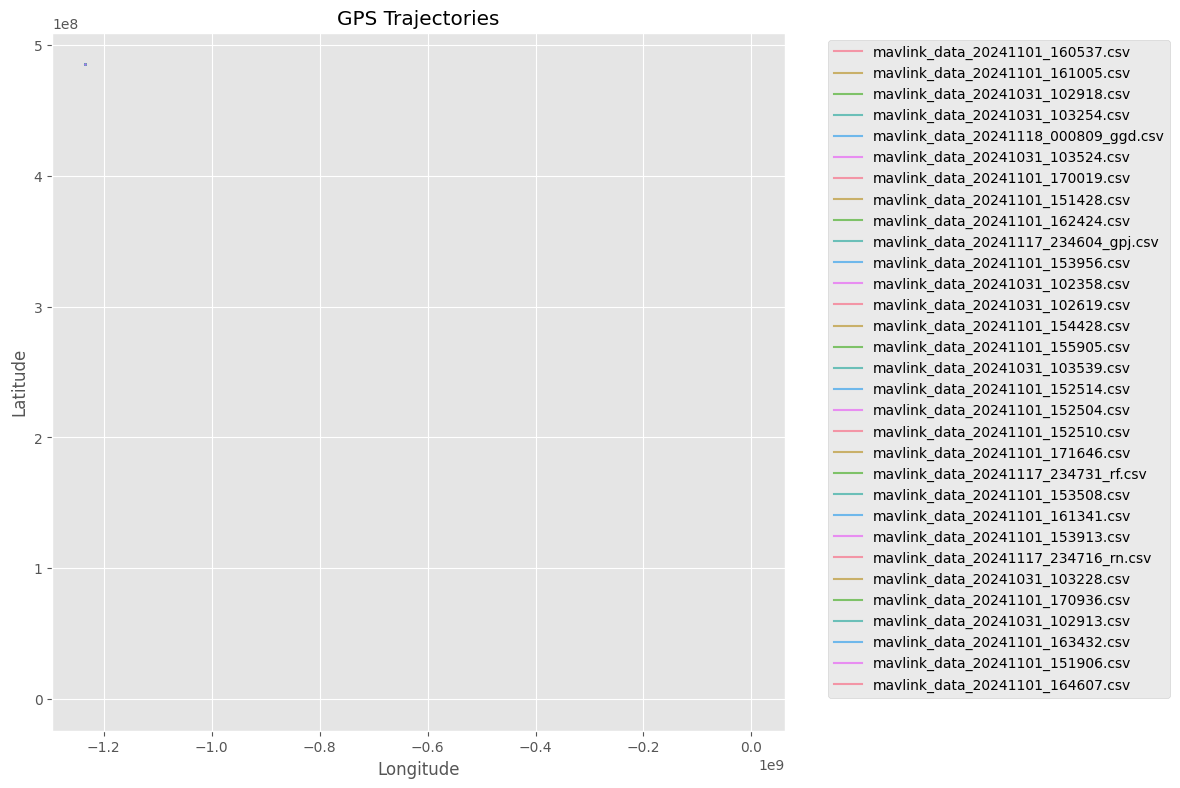

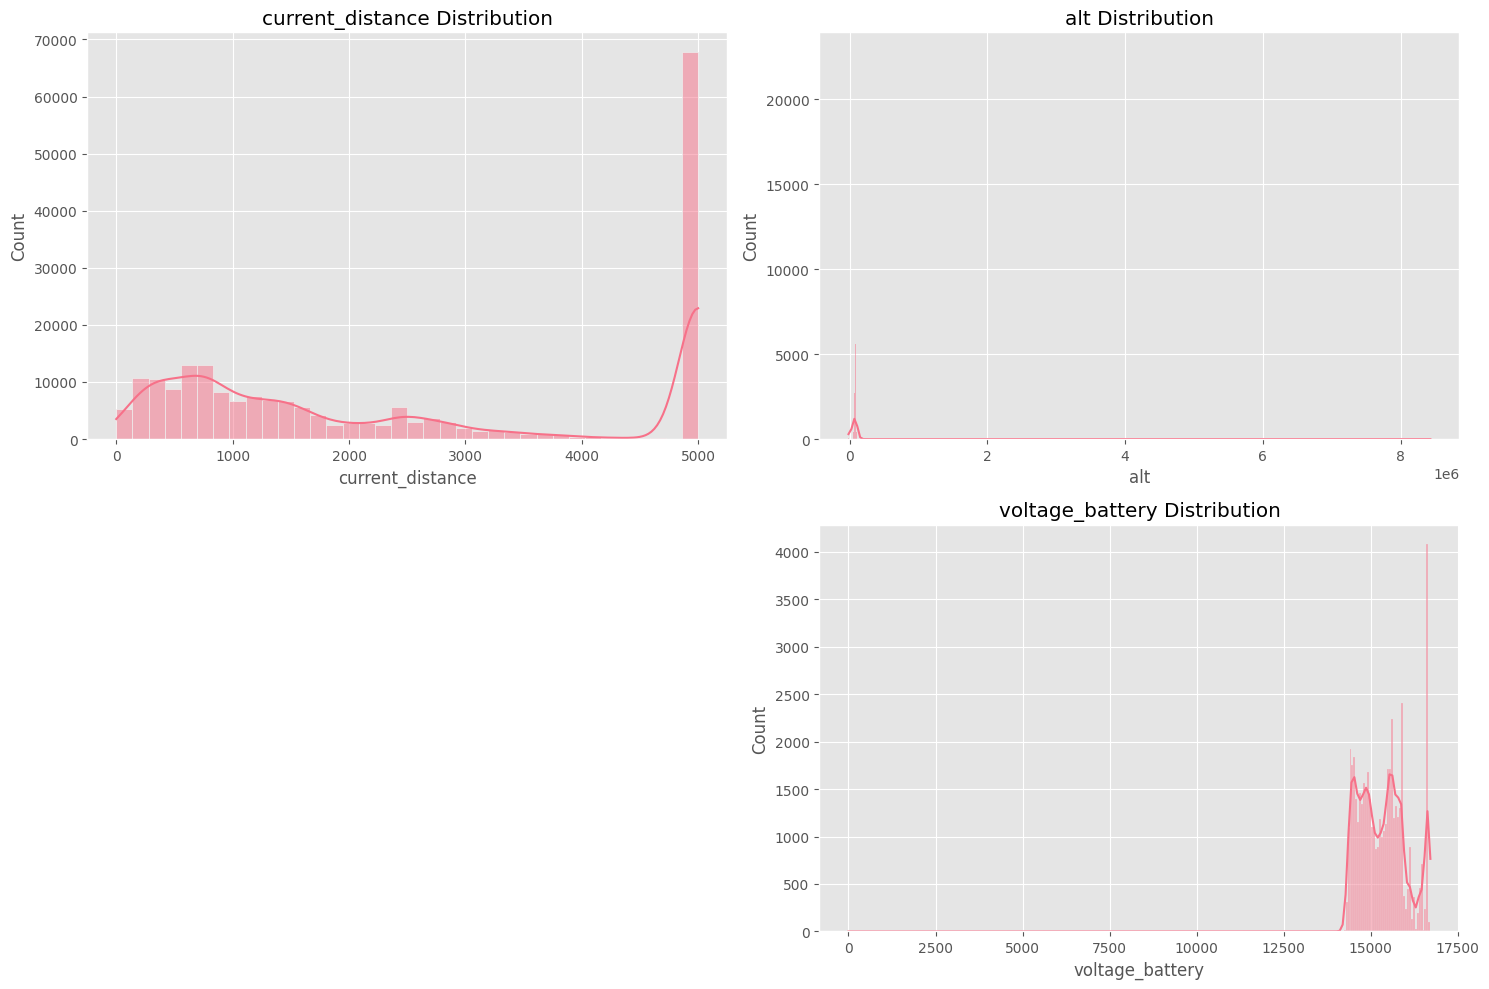

/var/folders/vt/19l5xdgn5dqbwvxb6rrxvyyc0000gn/T/ipykernel_51637/2125338050.py:44: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


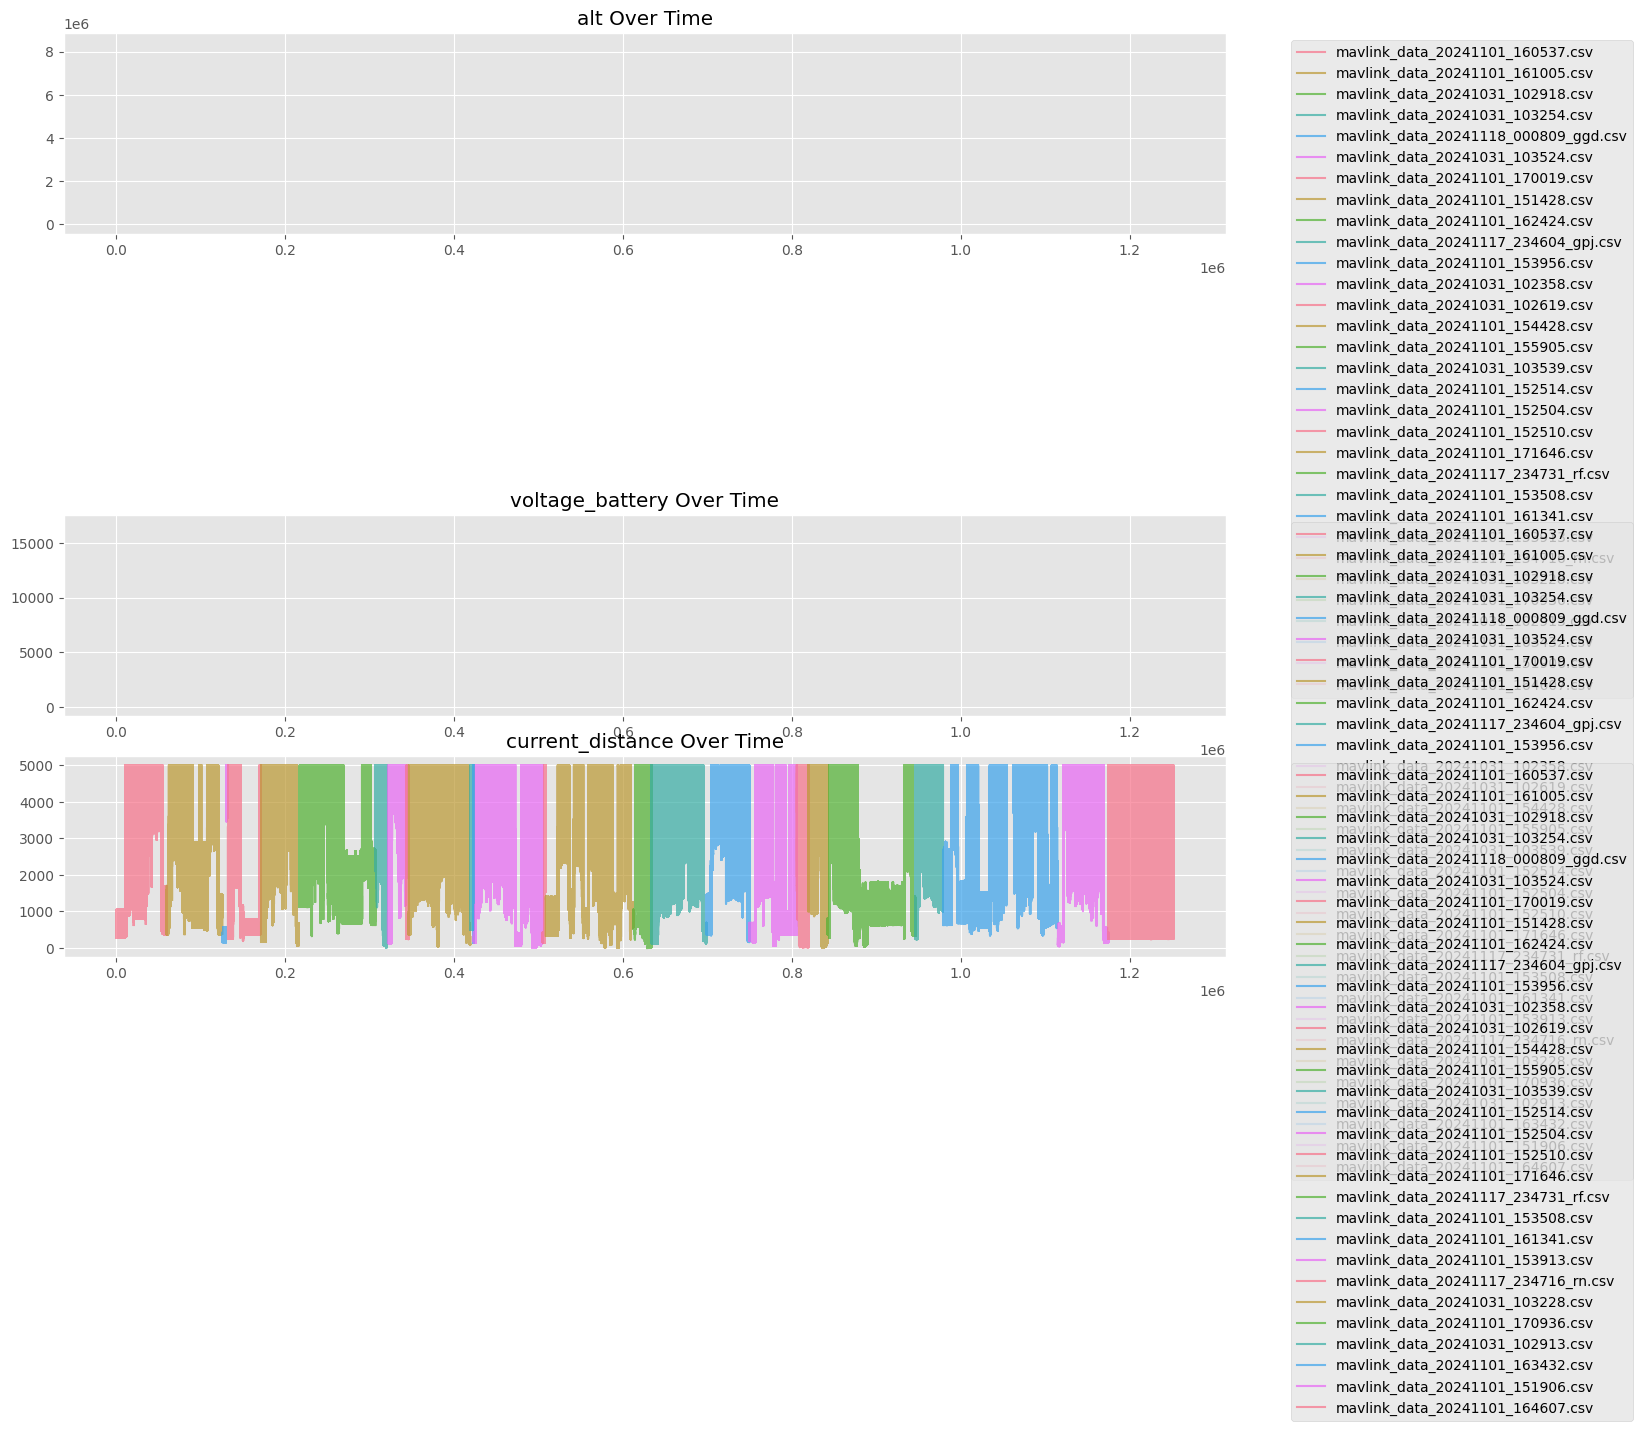

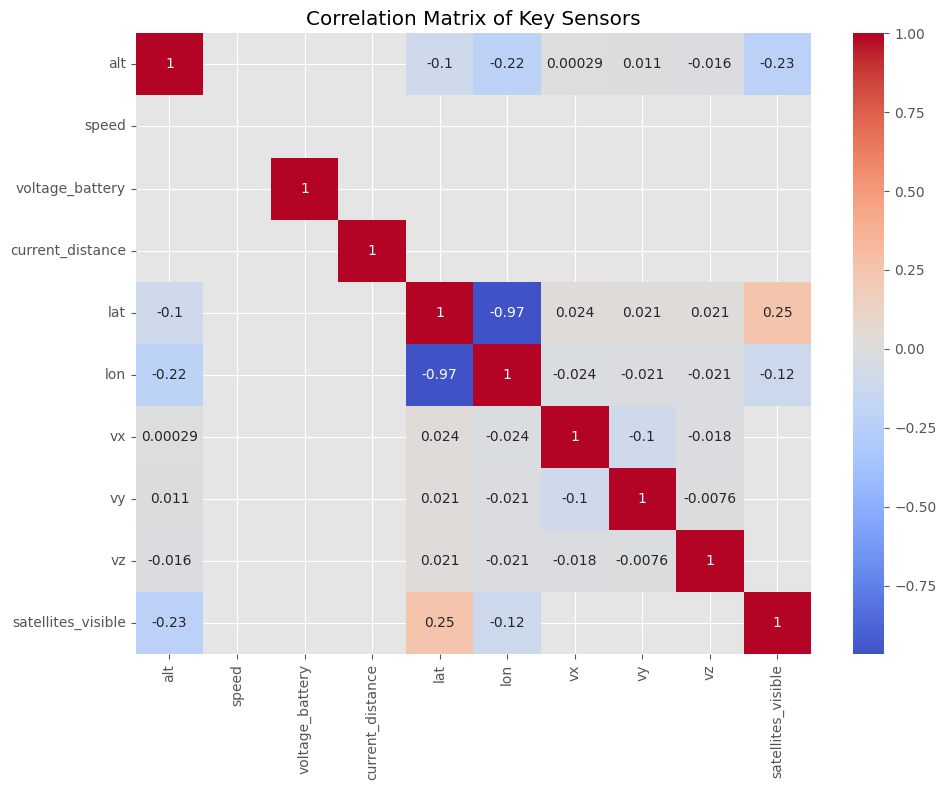

In [15]:
def plot_gps_trajectory(df):
    """Plot GPS trajectories"""
    plt.figure(figsize=(12, 8))
    for file in df['source_file'].unique():
        file_data = df[df['source_file'] == file]
        plt.plot(file_data['longitude'], file_data['latitude'], 
                label=file, alpha=0.7)
    plt.title('GPS Trajectories')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_sensor_distributions(df):
    """Plot distributions of key sensor readings"""
    sensors = ['current_distance', 'alt', 'groundspeed', 'voltage_battery']
    plt.figure(figsize=(15, 10))
    
    for i, sensor in enumerate(sensors, 1):
        if sensor in df.columns:
            plt.subplot(2, 2, i)
            sns.histplot(df[sensor].dropna(), kde=True)
            plt.title(f'{sensor} Distribution')
            
    plt.tight_layout()
    plt.show()

def plot_time_series(df):
    """Plot time series of key measurements"""
    metrics = ['alt', 'groundspeed', 'voltage_battery', 'current_distance']
    plt.figure(figsize=(15, 12))
    
    for i, metric in enumerate(metrics, 1):
        if metric in df.columns:
            plt.subplot(len(metrics), 1, i)
            for file in df['source_file'].unique():
                file_data = df[df['source_file'] == file]
                plt.plot(file_data.index, file_data[metric], 
                        label=file, alpha=0.7)
            plt.title(f'{metric} Over Time')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Generate plots
plot_gps_trajectory(df)
plot_sensor_distributions(df)
plot_time_series(df)

# Correlation analysis
sensor_cols = ['alt', 'speed', 'voltage_battery', 'current_distance',
    'lat', 'lon', 'vx', 'vy', 'vz', 'satellites_visible']
corr_matrix = df[sensor_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Key Sensors')
plt.tight_layout()
plt.show()

## 3. Feature Engineering

Generated features: ['timestamp', 'gps_speed_3d', 'gps_speed_2d', 'gps_vert_speed', 'gps_hdop', 'gps_vdop', 'gps_total_dop', 'gps_speed_3d_roll_mean', 'gps_speed_3d_roll_std', 'gps_speed_3d_roll_skew', 'gps_speed_3d_diff', 'gps_speed_3d_diff2', 'gps_speed_2d_roll_mean', 'gps_speed_2d_roll_std', 'gps_speed_2d_roll_skew', 'gps_speed_2d_diff', 'gps_speed_2d_diff2', 'gps_vert_speed_roll_mean', 'gps_vert_speed_roll_std', 'gps_vert_speed_roll_skew', 'gps_vert_speed_diff', 'gps_vert_speed_diff2', 'gps_hdop_roll_mean', 'gps_hdop_roll_std', 'gps_hdop_roll_skew', 'gps_hdop_diff', 'gps_hdop_diff2', 'gps_vdop_roll_mean', 'gps_vdop_roll_std', 'gps_vdop_roll_skew', 'gps_vdop_diff', 'gps_vdop_diff2', 'gps_total_dop_roll_mean', 'gps_total_dop_roll_std', 'gps_total_dop_roll_skew', 'gps_total_dop_diff', 'gps_total_dop_diff2']

Feature statistics:
          timestamp  gps_speed_3d  gps_speed_2d  gps_vert_speed      gps_hdop  \
count  1.251729e+06  1.251729e+06  1.251729e+06    1.251729e+06  1.251729e+06 

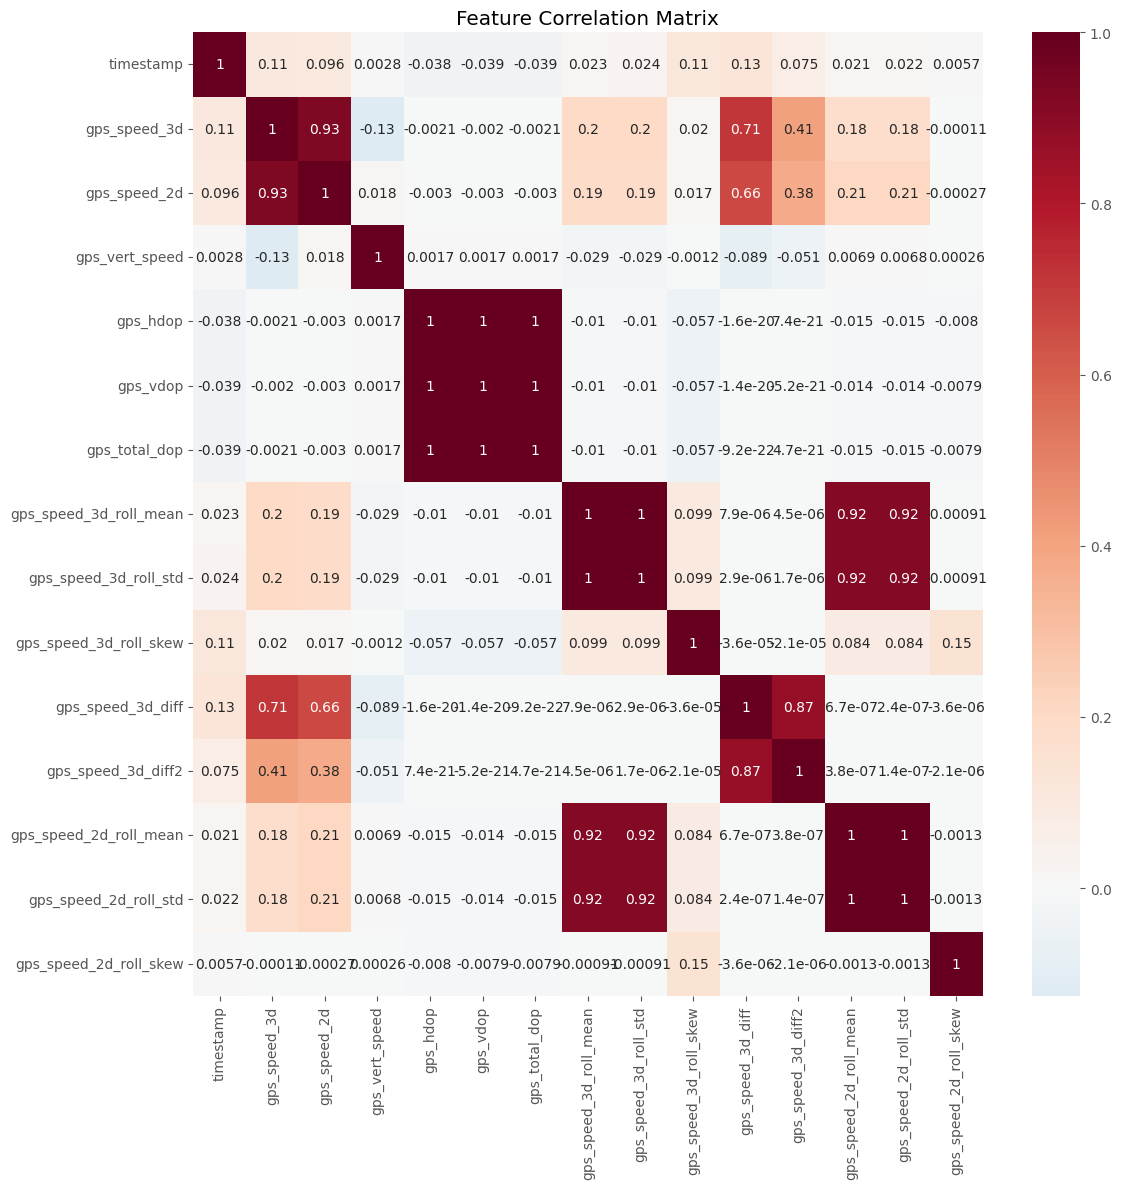

In [16]:
def engineer_features(df, window_size=20):
    """Advanced feature engineering for MAVLink data"""
    features = pd.DataFrame()
    
    # 1. Basic sensor features
    # Timestamp processing
    if 'time_boot_ms' in df.columns:
        features['timestamp'] = pd.to_numeric(df['time_boot_ms'], errors='coerce')
    elif 'time_usec' in df.columns:
        features['timestamp'] = pd.to_numeric(df['time_usec'], errors='coerce') / 1000

    # GPS features with quality metrics
    gps_cols = ['lat', 'lon', 'alt', 'vx', 'vy', 'vz']
    if all(col in df.columns for col in gps_cols):
        # 3D speed
        features['gps_speed_3d'] = np.sqrt(
            df['vx'].fillna(0)**2 +
            df['vy'].fillna(0)**2 +
            df['vz'].fillna(0)**2
        )
        # Horizontal speed
        features['gps_speed_2d'] = np.sqrt(
            df['vx'].fillna(0)**2 +
            df['vy'].fillna(0)**2
        )
        features['gps_vert_speed'] = df['vz'].fillna(0)
        
        # Position dilution of precision
        if 'eph' in df.columns and 'epv' in df.columns:
            features['gps_hdop'] = df['eph'].ffill()
            features['gps_vdop'] = df['epv'].ffill()
            features['gps_total_dop'] = np.sqrt(
                features['gps_hdop']**2 + features['gps_vdop']**2
            )

    # 2. Temporal features
    for col in features.columns:
        if col != 'timestamp':
            # Rolling statistics
            features[f'{col}_roll_mean'] = features[col].rolling(
                window_size, min_periods=1).mean()
            features[f'{col}_roll_std'] = features[col].rolling(
                window_size, min_periods=1).std().fillna(0)
            features[f'{col}_roll_skew'] = features[col].rolling(
                window_size, min_periods=1).skew().fillna(0)
            
            # Rate of change
            features[f'{col}_diff'] = features[col].diff().fillna(0)
            features[f'{col}_diff2'] = features[f'{col}_diff'].diff().fillna(0)

    # 3. Message sequence features
    if 'msgid' in df.columns:
        msg_counts = pd.get_dummies(df['msgid']).rolling(
            window_size, min_periods=1).sum()
        features = pd.concat([features, msg_counts], axis=1)

    # 4. Cross-sensor correlation features
    sensor_cols = ['alt', 'groundspeed', 'current_distance']
    if all(col in df.columns for col in sensor_cols):
        features['alt_distance_corr'] = (
            df['alt'].rolling(window_size).corr(df['current_distance'])
        ).fillna(0)
        
        features['speed_consistency'] = np.abs(
            df['groundspeed'] - features['gps_speed_2d']
        )

    # Clean up
    features = features.fillna(0)
    features = features.replace([np.inf, -np.inf], 0)
    
    return features

# Generate features
X = engineer_features(df)

# Display feature statistics
print("Generated features:", X.columns.tolist())
print("\nFeature statistics:")
print(X.describe())

# Plot correlation matrix of main features
plt.figure(figsize=(12, 12))
main_features = [col for col in X.columns if not col.startswith('msgid')][:15]
sns.heatmap(X[main_features].corr(), annot=True, cmap='RdBu_r', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 5. Model Training

In [19]:
def train_and_tune_models(X_train, y_train, contamination=0.1):
    """Train and tune multiple anomaly detection models"""
    models = {}
    
    # 1. Isolation Forest with optimized parameters
    print("Training Isolation Forest...")
    iso_params = {
        'n_estimators': [100, 200],
        'max_samples': ['auto', 100],
        'contamination': [contamination],
        'max_features': [0.8, 1.0],
        'bootstrap': [True, False]
    }
    iso_forest = IsolationForest(
        n_estimators=200,
        max_samples='auto',
        contamination=contamination,
        max_features=1.0,
        bootstrap=True,
        random_state=42
    )
    iso_forest.fit(X_train)
    models['iso_forest'] = iso_forest
    
    # 2. LOF with optimized parameters
    print("Training LOF...")
    lof_params = {
        'n_neighbors': [10, 20, 30],
        'contamination': [contamination],
        'metric': ['euclidean', 'manhattan']
    }
    lof = LocalOutlierFactor(
        n_neighbors=20,
        contamination=contamination,
        novelty=True
    )
    lof.fit(X_train)
    models['lof'] = lof
    
    # 3. Autoencoder
    print("Training Autoencoder...")
    input_dim = X_train.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu')(encoded)
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    autoencoder.fit(
        X_train, X_train,
        epochs=10,
        batch_size=32,
        validation_split=0.1,
        verbose=0
    )
    models['autoencoder'] = autoencoder
    
    return models

# Train models
models = train_and_tune_models(X_train, y_train)

print("\nModel parameters:")
for name, model in models.items():
    if name != 'autoencoder':
        print(f"\n{name}:")
        print(model.get_params())

Training Isolation Forest...
Training LOF...
Training Autoencoder...

Model parameters:

iso_forest:
{'bootstrap': True, 'contamination': 0.1, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 200, 'n_jobs': None, 'random_state': 42, 'verbose': 0, 'warm_start': False}

lof:
{'algorithm': 'auto', 'contamination': 0.1, 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 20, 'novelty': True, 'p': 2}


## 5. Model Evaluation

/Users/dogrod/Developer/UVIC/meng-project/.venv/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


5868/5868 ━━━━━━━━━━━━━━━━━━━━ 2s 264us/step


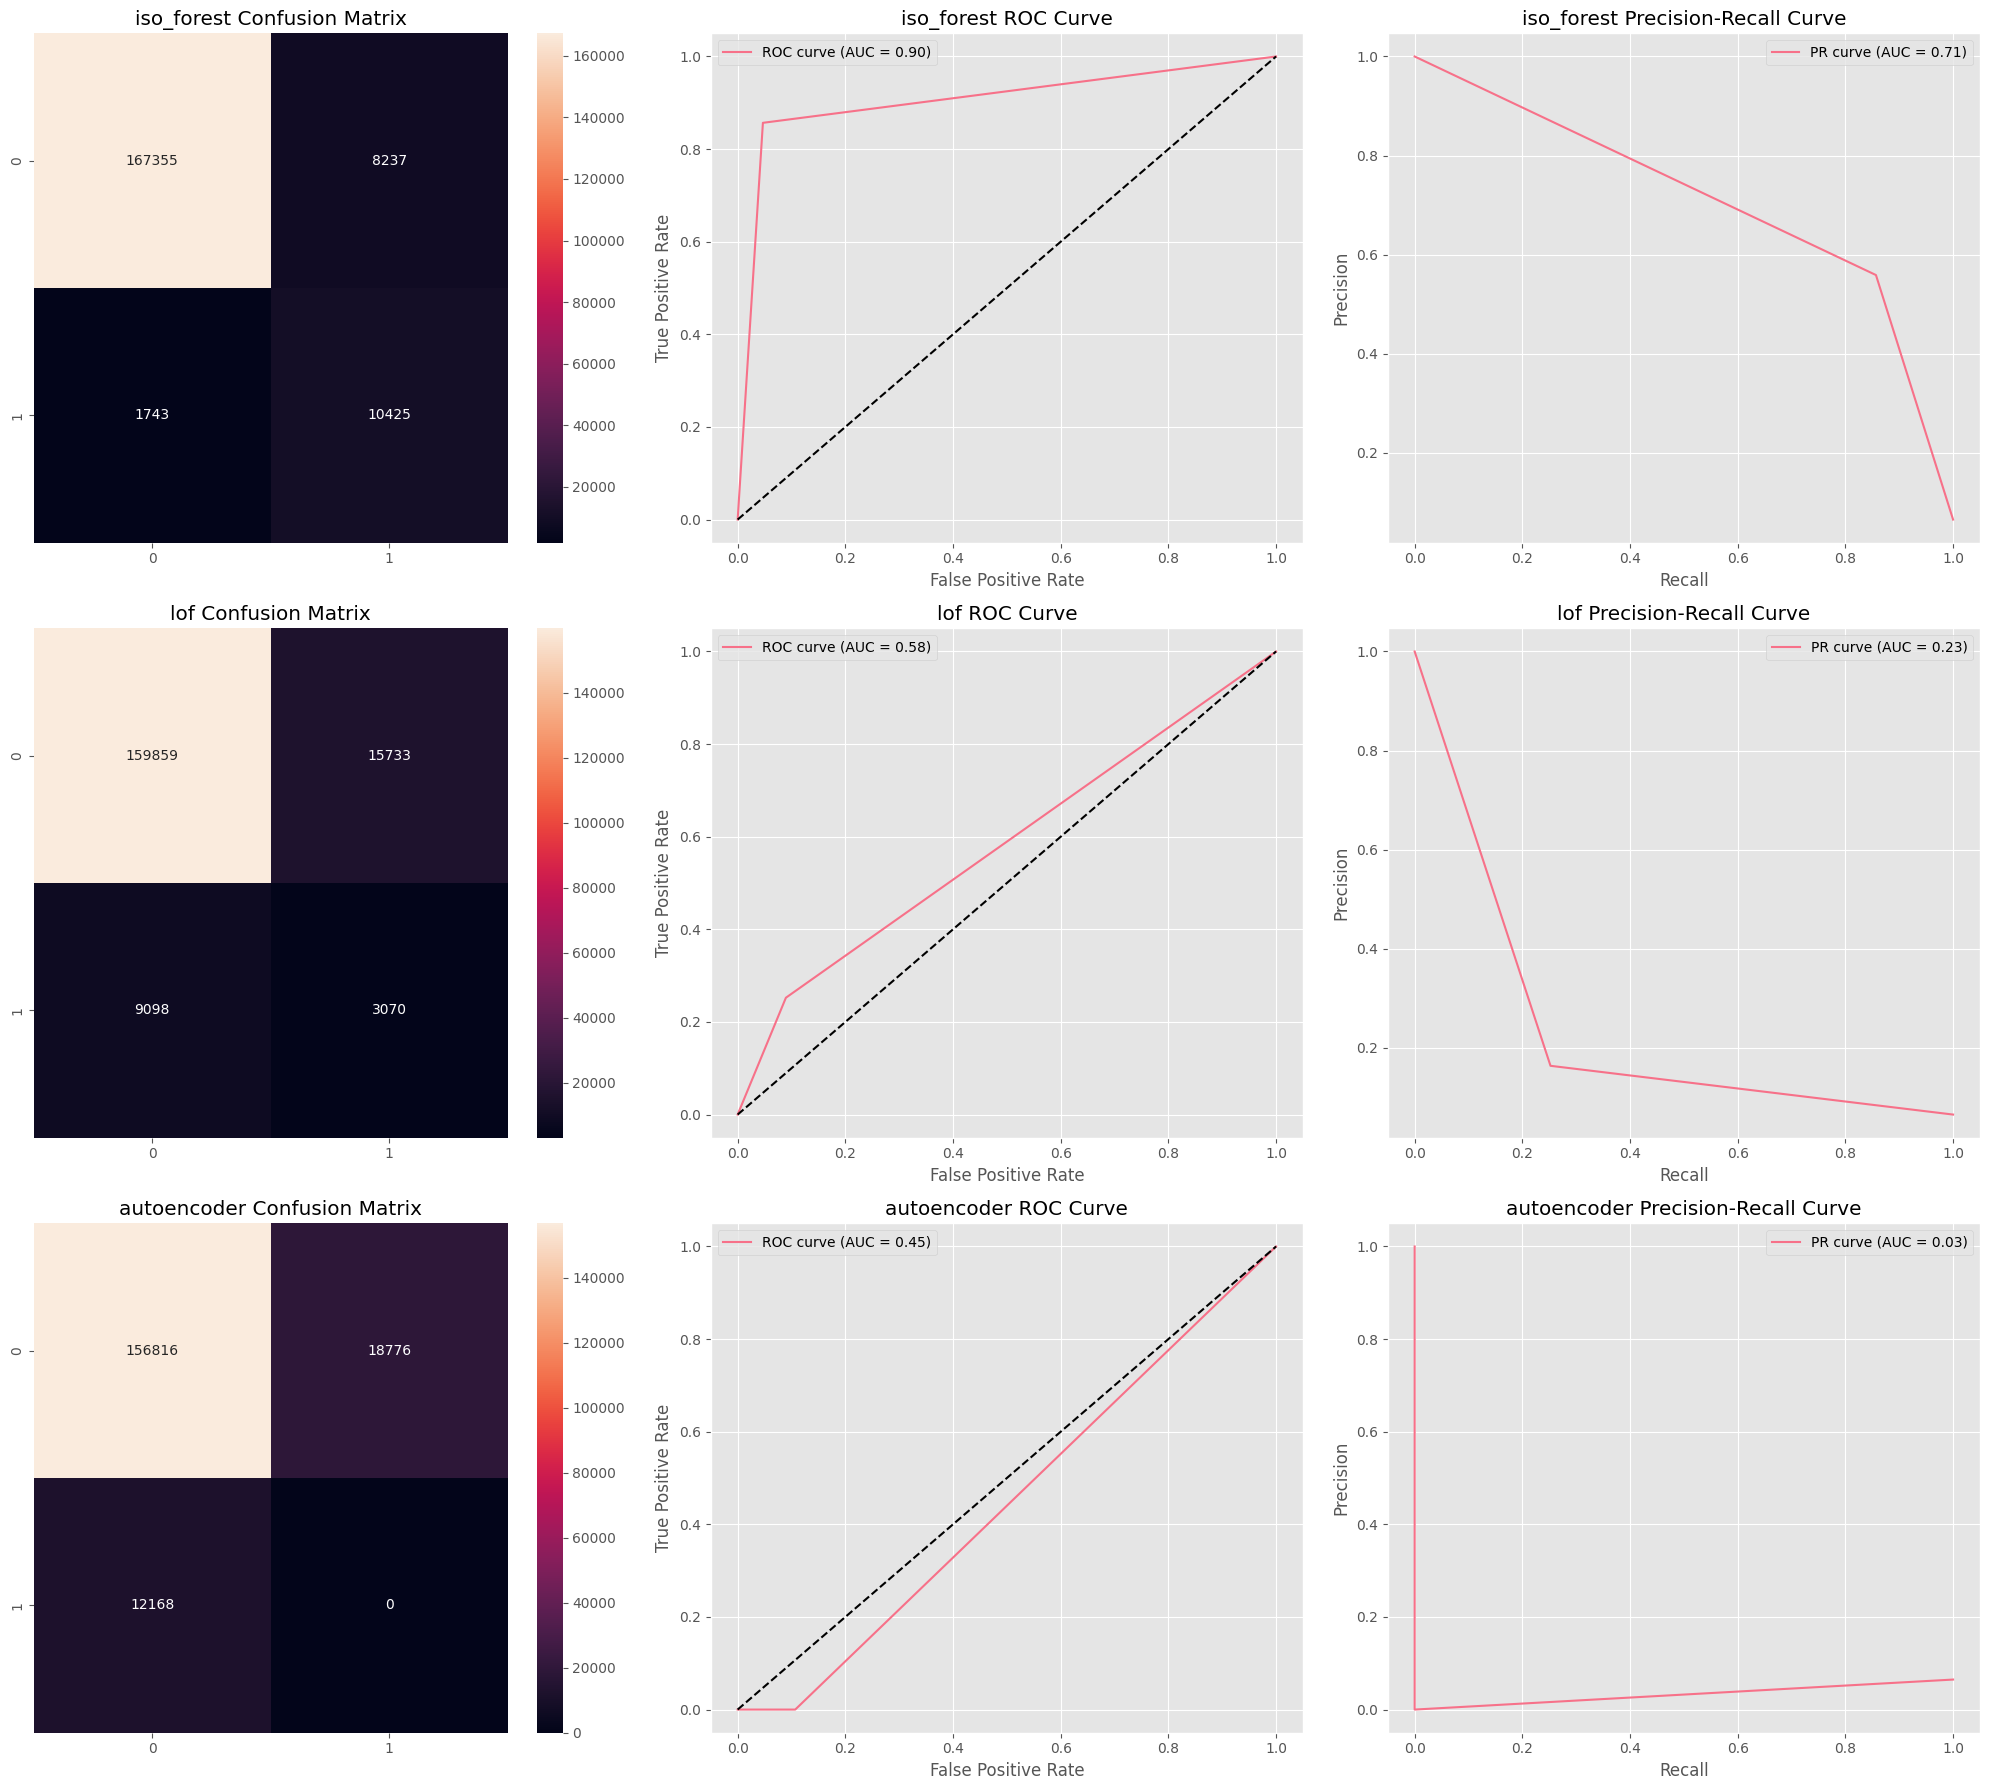


iso_forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97    175592
           1       0.56      0.86      0.68     12168

    accuracy                           0.95    187760
   macro avg       0.77      0.90      0.82    187760
weighted avg       0.96      0.95      0.95    187760


lof Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93    175592
           1       0.16      0.25      0.20     12168

    accuracy                           0.87    187760
   macro avg       0.55      0.58      0.56    187760
weighted avg       0.90      0.87      0.88    187760


autoencoder Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91    175592
           1       0.00      0.00      0.00     12168

    accuracy                           0.84    187760
   macro avg       0.46      

In [20]:
def evaluate_models(models, X_test, y_test):
    """Comprehensive model evaluation"""
    results = {}
    
    fig, axes = plt.subplots(len(models), 3, figsize=(20, 6*len(models)))
    
    for i, (name, model) in enumerate(models.items()):
        if name == 'autoencoder':
            # For autoencoder, use reconstruction error
            pred_scores = -np.mean(
                np.square(X_test - model.predict(X_test)), axis=1)
            y_pred = (pred_scores > np.percentile(pred_scores, 90)).astype(int)
        else:
            y_pred = model.predict(X_test)
            y_pred = (y_pred == -1).astype(int)
        
        # Calculate metrics
        results[name] = {}
        results[name]['confusion_matrix'] = confusion_matrix(y_test, y_pred)
        results[name]['classification_report'] = classification_report(y_test, y_pred)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        results[name]['roc_auc'] = auc(fpr, tpr)
        
        # Precision-Recall curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        results[name]['pr_auc'] = auc(recall, precision)
        
        # Plot results
        # Confusion Matrix
        sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d',
                   ax=axes[i, 0])
        axes[i, 0].set_title(f'{name} Confusion Matrix')
        
        # ROC Curve
        axes[i, 1].plot(fpr, tpr,
                       label=f'ROC curve (AUC = {results[name]["roc_auc"]:.2f})')
        axes[i, 1].plot([0, 1], [0, 1], 'k--')
        axes[i, 1].set_title(f'{name} ROC Curve')
        axes[i, 1].set_xlabel('False Positive Rate')
        axes[i, 1].set_ylabel('True Positive Rate')
        axes[i, 1].legend()
        
        # Precision-Recall Curve
        axes[i, 2].plot(recall, precision,
                       label=f'PR curve (AUC = {results[name]["pr_auc"]:.2f})')
        axes[i, 2].set_title(f'{name} Precision-Recall Curve')
        axes[i, 2].set_xlabel('Recall')
        axes[i, 2].set_ylabel('Precision')
        axes[i, 2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print classification reports
    for name, metrics in results.items():
        print(f"\n{name} Classification Report:")
        print(metrics['classification_report'])
    
    return results

# Evaluate models
results = evaluate_models(models, X_test, y_test)

# Compare model performances
model_comparison = pd.DataFrame({
    'Model': results.keys(),
    'ROC AUC': [r['roc_auc'] for r in results.values()],
    'PR AUC': [r['pr_auc'] for r in results.values()],
    'False Positives': [r['confusion_matrix'][0,1] for r in results.values()],
    'False Negatives': [r['confusion_matrix'][1,0] for r in results.values()]
})

print("\nModel Comparison:")
print(model_comparison)

Scores: -0.30129836984927977


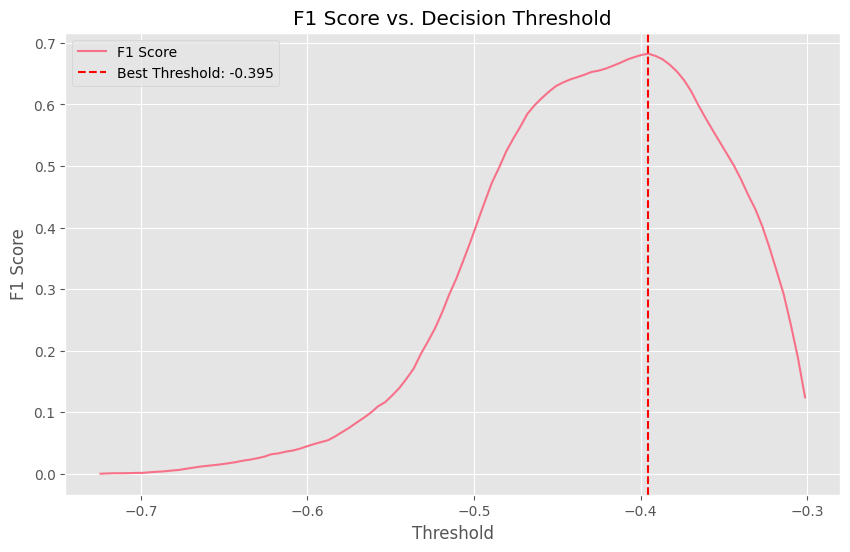

Best threshold: -0.395
Best F1 score: 0.682


In [28]:
def optimize_isolation_forest_threshold(model, X_val, y_val, thresholds=None):
    """
    Find the optimal decision threshold for Isolation Forest anomaly detection.
    
    Parameters:
    model: Trained IsolationForest model
    X_val: Validation features
    y_val: Validation labels (1 for anomaly, 0 for normal)
    thresholds: List of threshold values to try (default: -0.5 to 0.5)
    
    Returns:
    best_threshold: Optimal threshold value
    best_f1: F1 score at optimal threshold
    all_metrics: Dictionary with metrics at different thresholds
    """
    import numpy as np
    from sklearn.metrics import f1_score
    import matplotlib.pyplot as plt
    
    # Get model decision scores
    scores = model.score_samples(X_val)

    print(f"Scores: {scores.max()}")
    
    # Define thresholds to try
    if thresholds is None:
        thresholds = np.linspace(scores.min(), scores.max(), 100)
    
    # Store results
    results = {
        'threshold': [],
        'f1': [],
        'precision': [],
        'recall': []
    }
    
    # Try different thresholds
    best_f1 = 0
    best_threshold = 0
    
    for threshold in thresholds:
        # Convert scores to predictions using threshold
        y_pred = (scores < threshold).astype(int)
        
        # Calculate F1 score
        f1 = f1_score(y_val, y_pred)
        
        # Store results
        results['threshold'].append(threshold)
        results['f1'].append(f1)
        
        # Update best threshold if F1 improves
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(results['threshold'], results['f1'], label='F1 Score')
    plt.axvline(x=best_threshold, color='r', linestyle='--', 
                label=f'Best Threshold: {best_threshold:.3f}')
    plt.title('F1 Score vs. Decision Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Best threshold: {best_threshold:.3f}")
    print(f"Best F1 score: {best_f1:.3f}")
    
    return best_threshold, best_f1, results

# Example usage:
best_threshold, best_f1, metrics = optimize_isolation_forest_threshold(
    models['iso_forest'], 
    X_val,
    y_val
)


## 6. Time Series Analysis

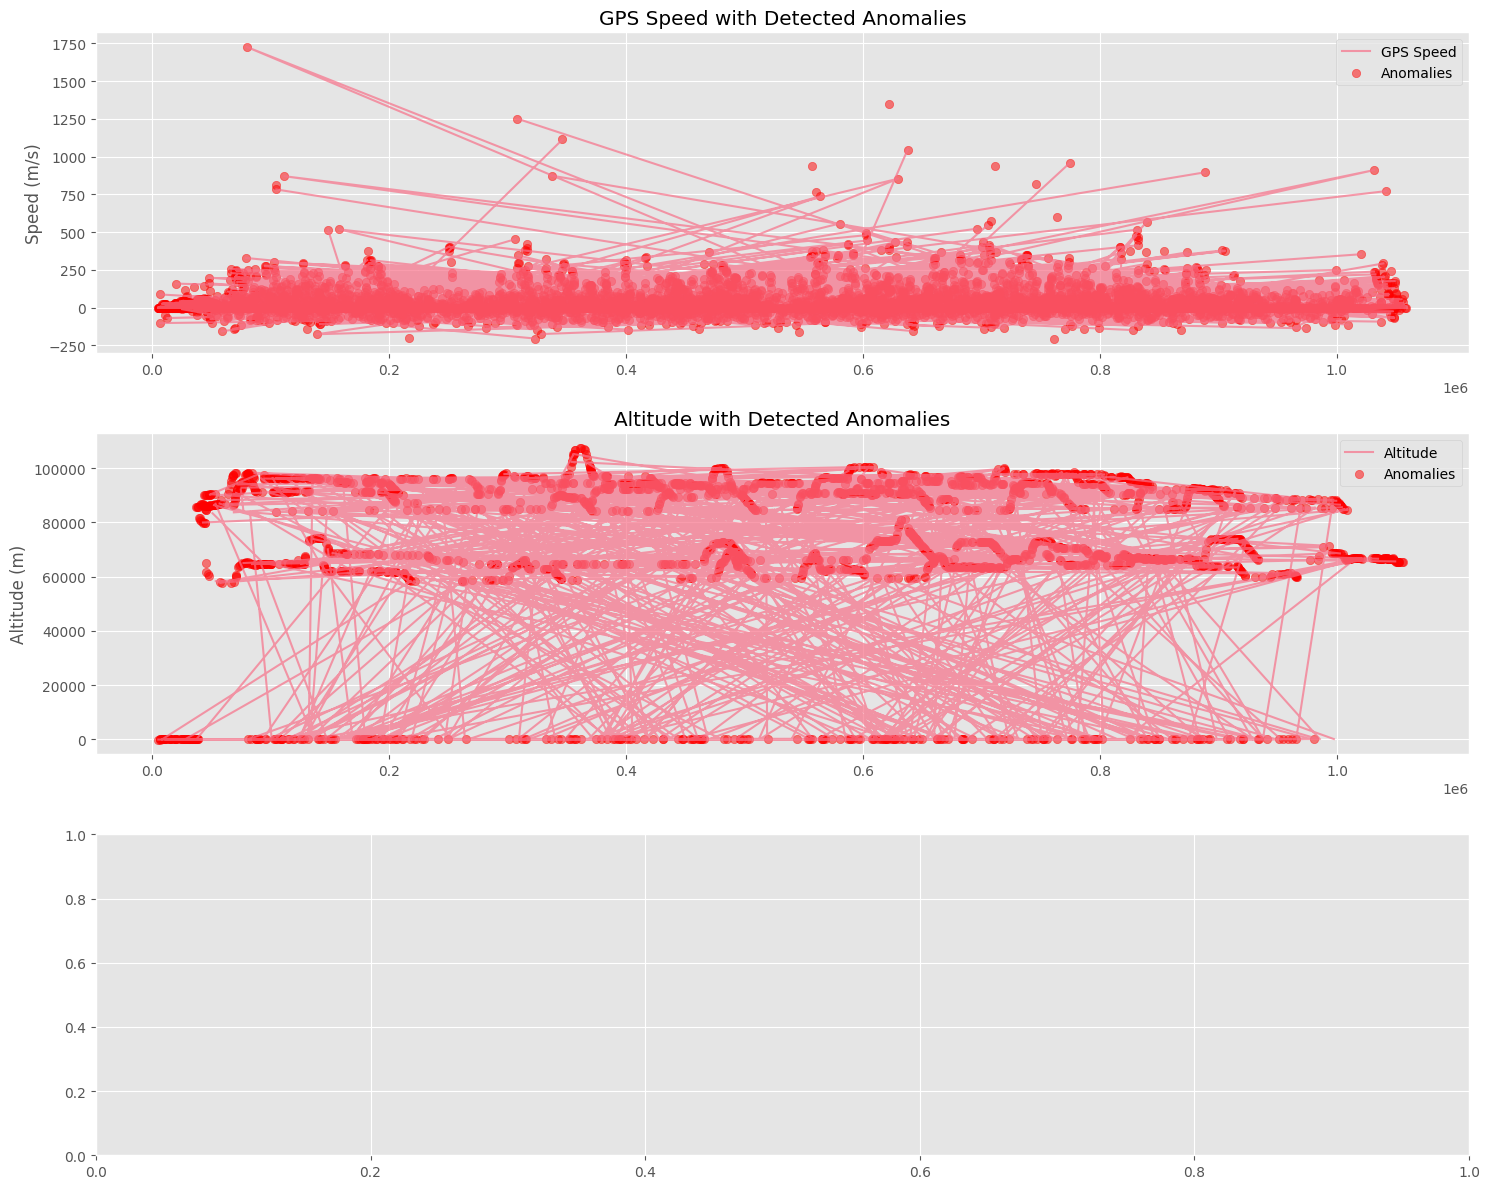


Anomaly Cluster Analysis:
Number of anomaly clusters: 2
Average cluster size: 9461.50
Largest cluster size: 11564


In [13]:
def analyze_time_series(df, X, y_pred, window_size=100):
    """Analyze anomalies in time series context"""
    
    # Create time windows for analysis
    timestamps = df['time_boot_ms'] if 'time_boot_ms' in df.columns else range(len(df))
    
    # Plot key metrics with detected anomalies
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # GPS Speed
    if 'gps_speed_3d' in X.columns:
        axes[0].plot(timestamps, X['gps_speed_3d'], label='GPS Speed', alpha=0.7)
        axes[0].scatter(timestamps[y_pred == 1], 
                       X.loc[y_pred == 1, 'gps_speed_3d'],
                       color='red', label='Anomalies', alpha=0.5)
        axes[0].set_title('GPS Speed with Detected Anomalies')
        axes[0].set_ylabel('Speed (m/s)')
        axes[0].legend()
    
    # Altitude
    if 'alt' in df.columns:
        axes[1].plot(timestamps, df['alt'], label='Altitude', alpha=0.7)
        axes[1].scatter(timestamps[y_pred == 1],
                       df.loc[y_pred == 1, 'alt'],
                       color='red', label='Anomalies', alpha=0.5)
        axes[1].set_title('Altitude with Detected Anomalies')
        axes[1].set_ylabel('Altitude (m)')
        axes[1].legend()
    
    # Message Rates
    if 'msgid' in df.columns:
        msg_rates = pd.Series(df['msgid']).rolling(window_size).count()
        axes[2].plot(timestamps, msg_rates, label='Message Rate', alpha=0.7)
        axes[2].scatter(timestamps[y_pred == 1],
                       msg_rates[y_pred == 1],
                       color='red', label='Anomalies', alpha=0.5)
        axes[2].set_title('Message Rate with Detected Anomalies')
        axes[2].set_ylabel('Messages per Window')
        axes[2].legend()
    
    plt.tight_layout()
    plt.show()

    # Analyze anomaly clusters
    anomaly_indices = np.where(y_pred == 1)[0]
    clusters = np.split(anomaly_indices, 
                       np.where(np.diff(anomaly_indices) > window_size)[0] + 1)
    
    print("\nAnomaly Cluster Analysis:")
    print(f"Number of anomaly clusters: {len(clusters)}")
    print(f"Average cluster size: {np.mean([len(c) for c in clusters]):.2f}")
    print(f"Largest cluster size: {max([len(c) for c in clusters])}")
    
    return clusters

# Get predictions from best model (using Isolation Forest as example)
best_model = models['iso_forest']
y_pred = (best_model.predict(X_test) == -1).astype(int)

# Analyze temporal patterns
clusters = analyze_time_series(df.iloc[X_test.index], X_test, y_pred)

## 7. Anomaly Type Analysis

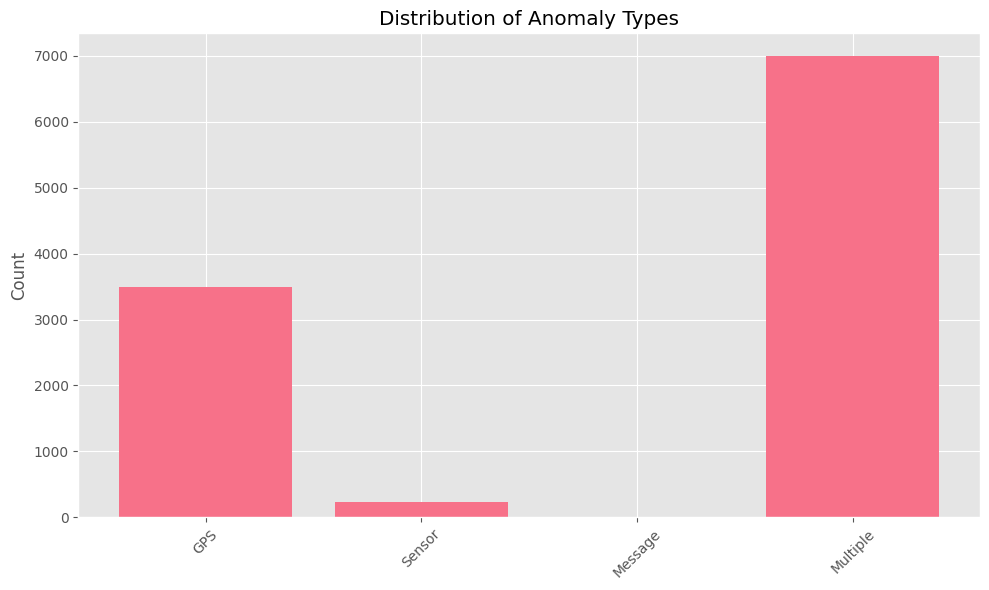


Anomaly Type Distribution:
GPS: 3493 (32.6%)
Sensor: 239 (2.2%)
Message: 0 (0.0%)
Multiple: 6989 (65.2%)


In [14]:
def analyze_anomaly_types(X_test, y_pred):
    """Analyze different types of detected anomalies"""
    
    anomaly_indices = y_pred == 1
    X_anomalies = X_test[anomaly_indices]
    
    # Initialize anomaly type counters
    anomaly_types = {
        'GPS': 0,
        'Sensor': 0,
        'Message': 0,
        'Multiple': 0
    }
    
    # Analyze each anomaly
    for idx in range(len(X_anomalies)):
        anomaly_row = X_anomalies.iloc[idx]
        
        # Check GPS anomalies
        gps_cols = [col for col in X_anomalies.columns if 'gps' in col]
        gps_anomaly = any(abs(stats.zscore(anomaly_row[gps_cols])) > 3)
        
        # Check sensor anomalies
        sensor_cols = [col for col in X_anomalies.columns 
                      if any(s in col for s in ['alt', 'speed', 'distance'])]
        sensor_anomaly = any(abs(stats.zscore(anomaly_row[sensor_cols])) > 3)
        
        # Check message anomalies
        msg_cols = [col for col in X_anomalies.columns if col.startswith('msgid')]
        msg_anomaly = any(anomaly_row[msg_cols] == 0)
        
        # Count anomaly types
        anomaly_count = sum([gps_anomaly, sensor_anomaly, msg_anomaly])
        if anomaly_count > 1:
            anomaly_types['Multiple'] += 1
        elif gps_anomaly:
            anomaly_types['GPS'] += 1
        elif sensor_anomaly:
            anomaly_types['Sensor'] += 1
        elif msg_anomaly:
            anomaly_types['Message'] += 1
    
    # Plot anomaly type distribution
    plt.figure(figsize=(10, 6))
    plt.bar(anomaly_types.keys(), anomaly_types.values())
    plt.title('Distribution of Anomaly Types')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Calculate percentages
    total_anomalies = sum(anomaly_types.values())
    print("\nAnomaly Type Distribution:")
    for atype, count in anomaly_types.items():
        print(f"{atype}: {count} ({count/total_anomalies*100:.1f}%)")
        
    return anomaly_types

# Analyze anomaly types
anomaly_types = analyze_anomaly_types(X_test, y_pred)

## 9. Save Model

In [15]:
def save_model_artifacts(models, scaler, feature_cols, output_dir='./model_output'):
    """Save trained models and preprocessing objects"""
    import joblib
    from pathlib import Path
    
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Save best model (assuming Isolation Forest)
    joblib.dump(models['iso_forest'], output_path / 'mavlink_anomaly_detector.joblib')
    
    # Save scaler
    joblib.dump(scaler, output_path / 'mavlink_scaler.joblib')
    
    # Save feature columns
    with open(output_path / 'mavlink_feature_columns.txt', 'w') as f:
        f.write('\n'.join(feature_cols))
    
    print(f"Model artifacts saved to {output_dir}")
    
def load_model_artifacts(model_dir='./model_output'):
    """Load saved model and preprocessing objects"""
    import joblib
    from pathlib import Path
    
    model_path = Path(model_dir)
    
    # Load model
    model = joblib.load(model_path / 'mavlink_anomaly_detector.joblib')
    
    # Load scaler
    scaler = joblib.load(model_path / 'mavlink_scaler.joblib')
    
    # Load feature columns
    with open(model_path / 'mavlink_feature_columns.txt', 'r') as f:
        feature_cols = f.read().splitlines()
        
    return model, scaler, feature_cols

# Save model artifacts
save_model_artifacts(models, StandardScaler(), X.columns, output_directory)

# Test loading
loaded_model, loaded_scaler, loaded_features = load_model_artifacts(output_directory)
print("\nLoaded model test prediction shape:", 
      loaded_model.predict(X_test.loc[:, loaded_features]).shape)

Model artifacts saved to ./model_output

Loaded model test prediction shape: (187760,)
